# Installation des dépendances

In [1]:
!sudo apt-get update && sudo apt-get -y install pkg-config libcairo2-dev pkg-config python3-dev

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [2]:
!pip install Pillow smartcrop matplotlib tensorflow numpy

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


# Preparation du dataset

In [3]:
%matplotlib inline

In [4]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import tensorflow.keras as K

2023-11-23 12:51:36.023397: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 12:51:36.135733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 12:51:36.135792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 12:51:36.135836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 12:51:36.147964: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 12:51:38.368416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [5]:
from pathlib import Path

path_to_dataset = Path("data/dataset_dojo")
path_to_cropped = path_to_dataset / "cropped"
path_to_models = Path("out/models")

img_height = 300
img_width = 300

In [6]:
import tensorflow as tf
from modules import dataload

training_dataset = dataload.create_set(path_to_cropped, "training")
validation_dataset = dataload.create_set(path_to_cropped, "validation")

class_names = training_dataset.class_names
print(f"{class_names = }")
print(f"{len(class_names) = }")

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#TODO : Ajouter un split de test pour comparer les differents types de modèles

Found 0 images in data/dataset_dojo/cropped.
Found 800 files belonging to 8 classes.
Using 640 files for training.
Found 0 images in data/dataset_dojo/cropped.
Found 800 files belonging to 8 classes.
Using 160 files for validation.
class_names = ['celtis_australis', 'juniperus_procera', 'juniperus_thurifera', 'markhamia_lutea', 'milicia_excelsa', 'pino_halepensis', 'prunus_africana', 'unknown']
len(class_names) = 8


In [7]:
import numpy as np
from tensorflow import keras as K

image_batch, _ = next(iter(training_dataset))
first_image = image_batch[0]
print(f"Initial image values interval : [{np.min(first_image)}, {np.max(first_image)}]")

normalization_layer = K.layers.Rescaling(1./255)
normalized_ds = training_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(f"Normalized image values interval : [{np.min(first_image)}, {np.max(first_image)}]")

Initial image values interval : [3.682278871536255, 255.0]
Normalized image values interval : [0.0, 1.0]


# Modèle simple

In [8]:
from modules.model import create_model

num_classes = len(class_names)

model = create_model(
    input_shape=(img_height, img_width, 3),
    output_dim=num_classes
)

2023-11-23 12:51:43.651680: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44859392 exceeds 10% of free system memory.
2023-11-23 12:51:43.680173: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44859392 exceeds 10% of free system memory.
2023-11-23 12:51:43.693001: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44859392 exceeds 10% of free system memory.


In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)       

## Entrainement du modèle simple

In [11]:
epochs=10
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/10


2023-11-23 12:51:44.350720: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44859392 exceeds 10% of free system memory.
2023-11-23 12:51:44.369082: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44859392 exceeds 10% of free system memory.


20/20 [==============================] - 44s 2s/step - loss: 3.0232 - accuracy: 0.1344 - val_loss: 1.9571 - val_accuracy: 0.1250
Epoch 2/10
20/20 [==============================] - 41s 2s/step - loss: 1.8621 - accuracy: 0.2562 - val_loss: 1.6547 - val_accuracy: 0.3750
Epoch 3/10
20/20 [==============================] - 41s 2s/step - loss: 1.6197 - accuracy: 0.4250 - val_loss: 1.6405 - val_accuracy: 0.3000
Epoch 4/10
20/20 [==============================] - 41s 2s/step - loss: 1.3949 - accuracy: 0.4875 - val_loss: 1.4844 - val_accuracy: 0.4125
Epoch 5/10
20/20 [==============================] - 41s 2s/step - loss: 0.9960 - accuracy: 0.6875 - val_loss: 1.6227 - val_accuracy: 0.3875
Epoch 6/10
20/20 [==============================] - 40s 2s/step - loss: 0.6559 - accuracy: 0.7797 - val_loss: 1.7045 - val_accuracy: 0.3750
Epoch 7/10
20/20 [==============================] - 41s 2s/step - loss: 0.4721 - accuracy: 0.8687 - val_loss: 2.3273 - val_accuracy: 0.4187
Epoch 8/10
20/20 [=============

## Visualisation des métriques

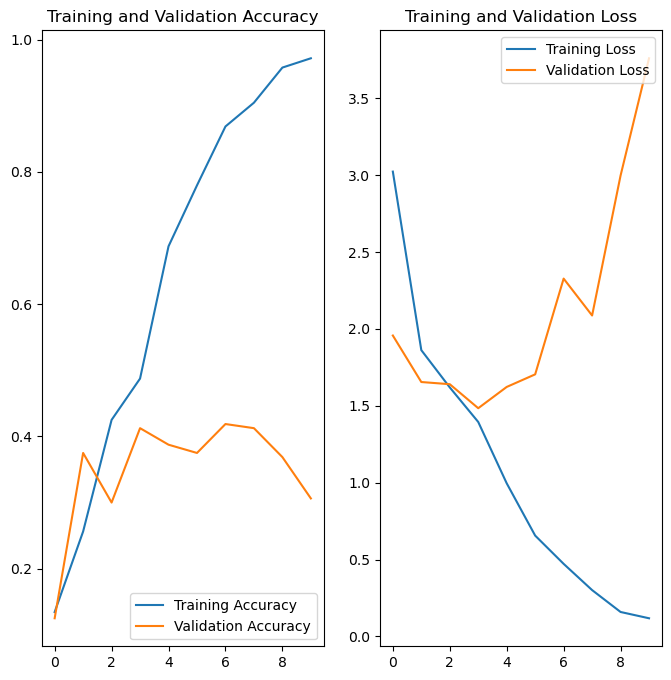

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Sauvegarde

In [13]:
from modules.model import save_model
save_model(
    model_folder=path_to_models / "simple",
    model=model,
)

# Augmentation du modele

## Illustration de la couche d'augmentation

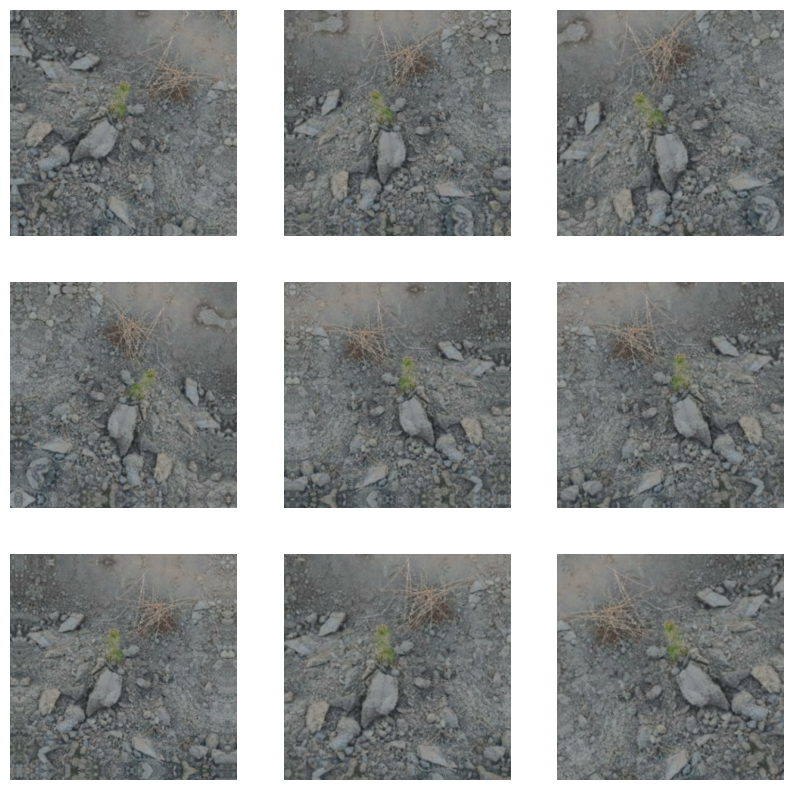

In [14]:
data_augmentation = K.Sequential([
    K.layers.RandomFlip(
        "horizontal",
        input_shape=(img_height, img_width, 3)
    ),
    K.layers.RandomRotation(0.1),
    K.layers.RandomZoom(0.1),
])

plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Déclaration du modèle augmenté

In [15]:
augmented_model = create_model(
    input_shape=(img_height, img_width, 3),
    output_dim=num_classes,
    augmented=True,
)

In [16]:
augmented_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [17]:
augmented_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 150, 150, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                 

## Entrainement du modèle augmenté

In [18]:
history_aug = augmented_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
20/20 [==============================] - 48s 2s/step - loss: 2.3898 - accuracy: 0.1500 - val_loss: 1.9895 - val_accuracy: 0.2062
Epoch 2/10
20/20 [==============================] - 41s 2s/step - loss: 1.8649 - accuracy: 0.2297 - val_loss: 1.6840 - val_accuracy: 0.2625
Epoch 3/10
20/20 [==============================] - 25s 1s/step - loss: 1.7771 - accuracy: 0.2562 - val_loss: 1.5864 - val_accuracy: 0.3562
Epoch 4/10
20/20 [==============================] - 43s 2s/step - loss: 1.7119 - accuracy: 0.3141 - val_loss: 1.7355 - val_accuracy: 0.3000
Epoch 5/10
20/20 [==============================] - 44s 2s/step - loss: 1.6927 - accuracy: 0.2937 - val_loss: 1.6275 - val_accuracy: 0.3250
Epoch 6/10
20/20 [==============================] - 44s 2s/step - loss: 1.6282 - accuracy: 0.3609 - val_loss: 1.5230 - val_accuracy: 0.4375
Epoch 7/10
20/20 [==============================] - 24s 1s/step - loss: 1.5195 - accuracy: 0.3828 - val_loss: 1.5689 - val_accuracy: 0.4437
Epoch 8/10
20/20 [==

## Sauvegarde et affichage des métriques

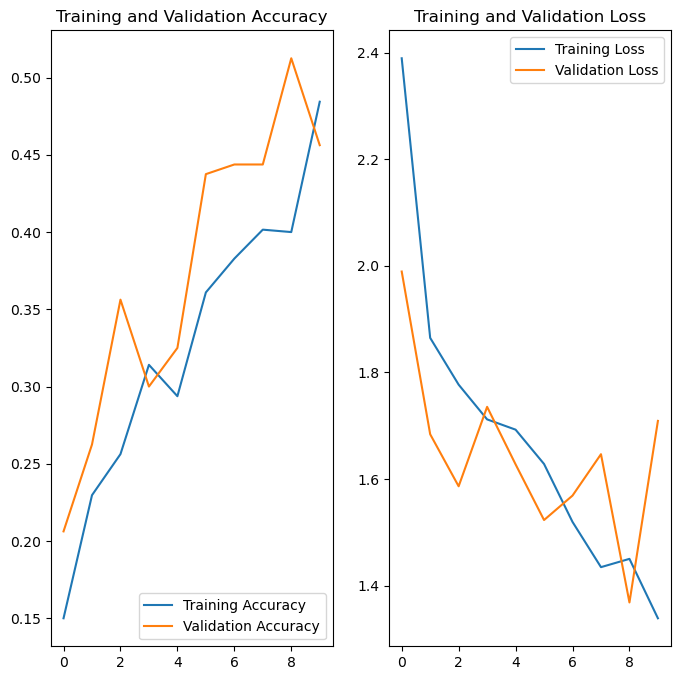

In [19]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Sauvegarde

In [20]:
from modules.model import save_model
save_model(
    model_folder=path_to_models / "augmented",
    model=augmented_model,
)

# Résultats

## Exemple d'inférence

In [21]:
import os
from PIL import Image

test_file_url = "data/dataset/other/albizia_coriaria/0b6917a968f1dd06d388133971761f0d.jpg"
im = Image.open(os.path.abspath("./" + test_file_url)) 

sunflower_path = tf.keras.utils.get_file(fname='test-file', origin='file://'+os.path.abspath("./" + test_file_url))

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

display(im)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/dojo/data/dataset/other/albizia_coriaria/0b6917a968f1dd06d388133971761f0d.jpg'

## Comparaison du modèle simple et du modèle augmenté

In [ ]:
## TODO maybe ?